# Практический проект
Анализ активности студентов онлайн-курса
<a href='https://stepik.org/course/129/syllabus'> Введение в анализ данных в R </a>. 
-------------------------------------------------------
### Описание данных
<b style='color:blue'>events_train.csv </b> - данные о действиях, которые совершают студенты со стэпами

 1. step_id - id стэпа
 2. user_id - анонимизированный id юзера
 3. timestamp - время наступления события в формате unix date
 4. action - событие, возможные значения: 
 - discovered - пользователь перешел на стэп
 - viewed - просмотр шага,
 - started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
 - passed - удачное решение практического шага

<b style='color:blue'> submissions_train.csv </b> - данные о времени и статусах сабмитов к практическим заданиям

1. step_id - id стэпа
2. timestamp - время отправки решения в формате unix date
3. submission_status - статус решения
4. user_id - анонимизированный id юзера
-------------------------------------------------------
### Предметная область и проблема
* Почему очень много пользователей записываются на онлайн-курсы, но так мало из них доходят до конца (около 5%)?
* Что можно сделать, чтобы улучшить метрику записавшихся/доходящих?
* Выявить на каких степах были проблемы у студентов; в какой момент они перестали учиться

Повышение проходимости курса не является самоцелью (этого легко добиться просто уменьшив объем курса), но интересно то, как можно повысить метрики в текущей ситуации (то есть не делая глобальных изменений)

In [84]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = [10, 5]

### Данные
1) Посмотреть на данные: о чем они рассказывают?  
2) Убедиться в их корректности


In [85]:
events_data = pd.read_csv('data/event_data_train.csv')
print('Число записей - ', len(events_data))
events_data.head(7)

Число записей -  3480703


,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632


In [86]:
submission_data = pd.read_csv('data/submissions_data_train.csv')
print('Число записей - ', len(submission_data))
submission_data.head(7)

Число записей -  509104


,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
5,31976,1434348188,correct,15853
6,31976,1478852055,correct,15853


### Первичное преобразование и представление данных

In [87]:
events_data['timestamp'] = pd.to_datetime(events_data['timestamp'], unit='s')
submission_data['timestamp'] = pd.to_datetime(submission_data['timestamp'], unit='s')


# первые действия на курсе
events_data.head(3)

,step_id,timestamp,action,user_id
0,32815,2015-06-15 04:00:48,viewed,17632
1,32815,2015-06-15 04:00:48,passed,17632
2,32815,2015-06-15 04:00:48,discovered,17632


In [36]:
# Какой период времени охватывают данные?
(events_data['timestamp'].max() - events_data['timestamp'].min())

Timedelta('1069 days 19:32:43')

In [37]:
(submission_data['timestamp'].max() - submission_data['timestamp'].min())

Timedelta('1069 days 19:04:43')

In [88]:
# добавим колонку с датой (только год-месяц-день), в которую произошло событие
events_data['date'] = events_data.timestamp.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,2015-06-15 04:00:48,viewed,17632,2015-06-15
1,32815,2015-06-15 04:00:48,passed,17632,2015-06-15
2,32815,2015-06-15 04:00:48,discovered,17632,2015-06-15
3,32811,2015-06-15 04:01:35,discovered,17632,2015-06-15
4,32811,2015-06-15 04:01:35,viewed,17632,2015-06-15


In [49]:
# сколько уникальных пользователей по каждому дню?
events_data.groupby('date')['user_id'].nunique().head()

date
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
Name: user_id, dtype: int64

Text(0, 0.5, 'число уникальных users')

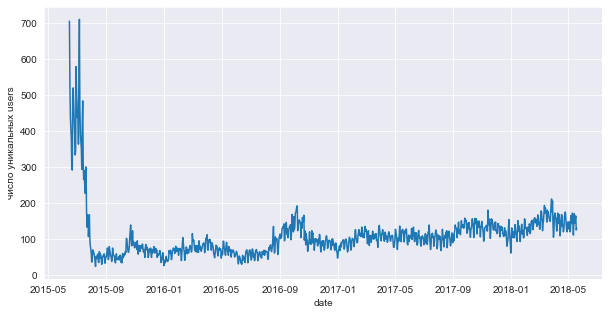

In [78]:
events_data.groupby('date')['user_id'].nunique().plot()
plt.ylabel('число уникальных users')

Как мы видим, наибольший наплыв людей происходил в начале курса (как раз тогда, когда были дедлайны). Затем наблюдается спад активности.

In [71]:
# как распределены пользователи по количеству баллов за курс ?
events_data[events_data['action']=='passed'].groupby('user_id', as_index=False) \
                                            .agg({'step_id':'count'}) \
                                            .rename(columns={'step_id':'count of passed'}) \
                                            .head()

,user_id,count of passed
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84


Text(0, 0.5, 'количество студентов')

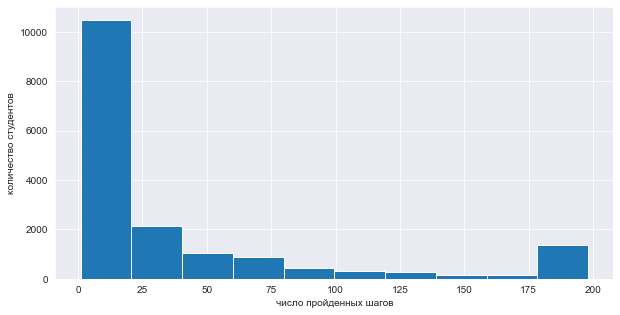

In [77]:
events_data[events_data['action']=='passed'].groupby('user_id', as_index=False) \
                                            .agg({'step_id':'count'}) \
                                            .rename(columns={'step_id':'count of passed'}) \
                                            ['count of passed'].hist()
plt.xlabel('число пройденных шагов')
plt.ylabel('количество студентов')

Как мы видим, число студентов падает с ростом числа пройденных степов. Это подтверждает (в некотором смысле) гипотезу о том, что студенты редко доходят до конца курса

**Ошибка**, которую мы совершили: не учли студентов, у которых нет пройденных шагов вообще

In [82]:
events_data[events_data['action']=='passed'].groupby('user_id', as_index=False) \
                                            .agg({'step_id':'count'}) \
                                            .rename(columns={'step_id':'count of passed'}).min()

user_id            2
count of passed    1
dtype: int64

In [91]:
# для решения воспользуемся pivot_table
pv = events_data.pivot_table(index='user_id', columns=['action'], values='step_id',
                       aggfunc='count', fill_value=0).reset_index()
pv.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Text(0, 0.5, 'количество студентов')

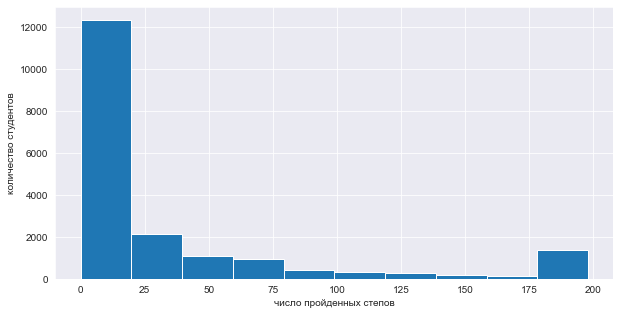

In [93]:
pv.passed.hist()
plt.xlabel('число пройденных степов')
plt.ylabel('количество студентов')